In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
from pokie import pokie, pokie_bootstrap

# Sample from GMM

In [2]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 2 Dimension

In [3]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 2
n_truth_samples = 1000  # Number of ground truth samples
num_posterior_samples = 1000  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 40.08it/s]


In [4]:
results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04235774 0.04344425 0.04424427 0.04573486 0.04714018 0.04861044
 0.04972567 0.050664   0.0514265  0.05209681 0.05237297 0.0522146
 0.05170561 0.05089204 0.0499462  0.04809963 0.0466098  0.04464569
 0.04371925 0.04259715 0.04175231]
Calibrated: [0.53879718 0.55261784 0.56279426 0.58175478 0.59963064 0.61833264
 0.63251855 0.64445424 0.65415338 0.66267973 0.6661926  0.66417803
 0.65770368 0.6473549  0.63532371 0.61183497 0.59288412 0.56790039
 0.55611586 0.5418426  0.5310961 ]


# 2D GMM Plots

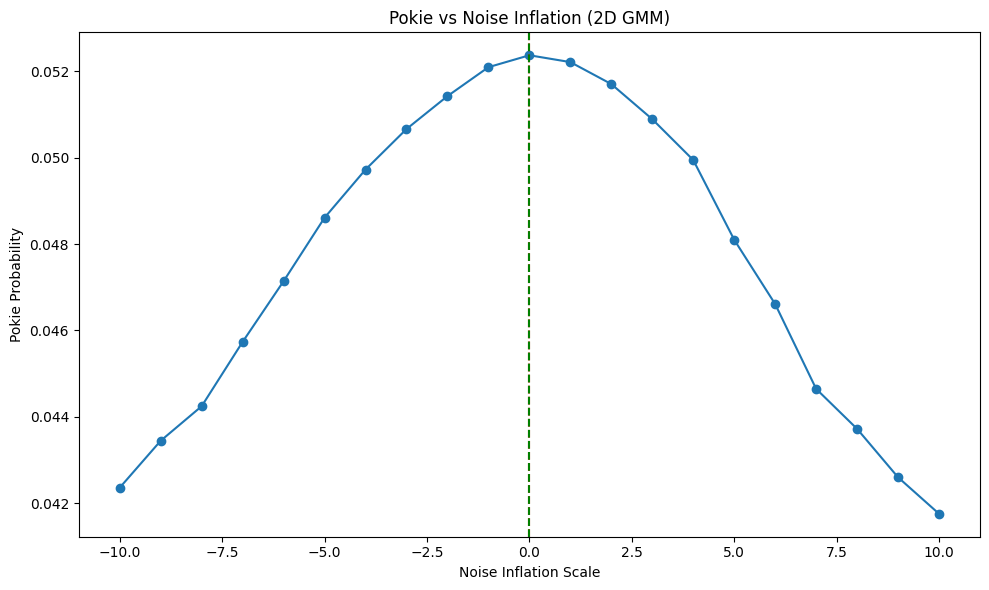

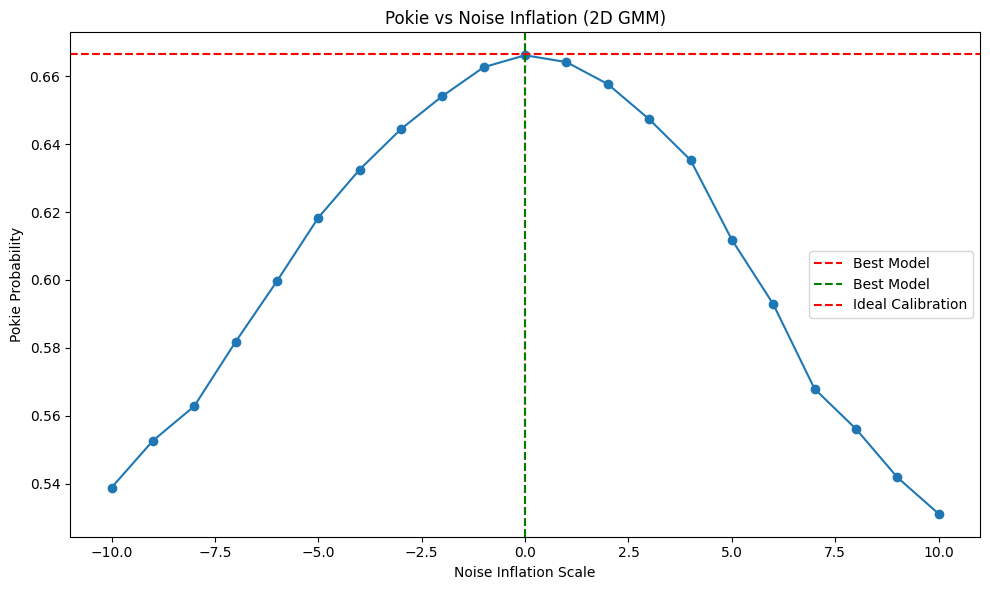

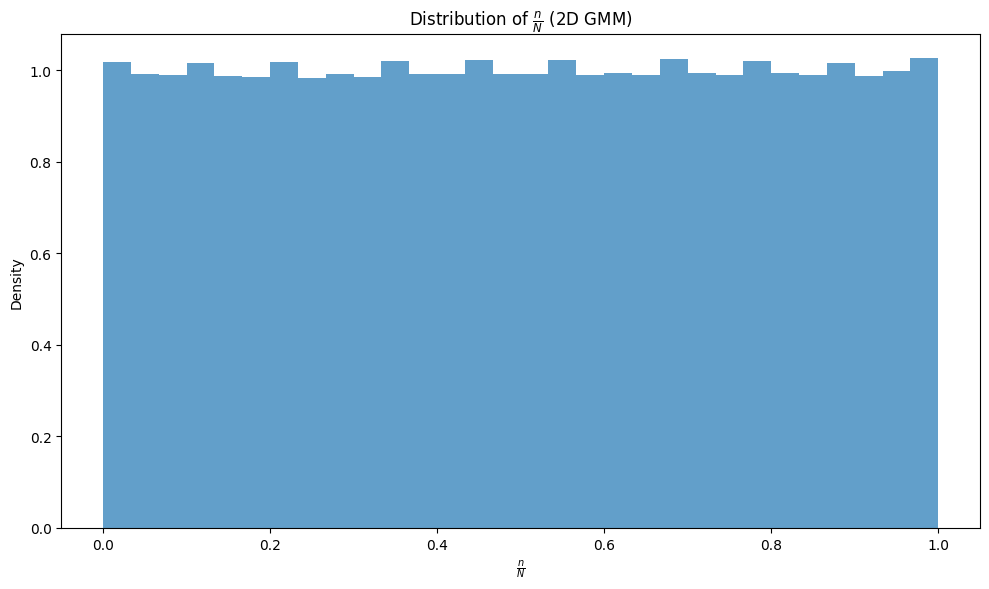

In [5]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_2D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_2D_GMM_Calibrated.pdf")
plt.show()

# Histogram of n/N values
plt.figure(figsize=(10, 6))
plt.hist(n_over_N_vals, bins=30, density=True, alpha=0.7)
plt.title(r"Distribution of $\frac{n}{N}$ (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/2D/Pokie_n_over_N_2D_GMM.pdf")
plt.show()

# 20 Dimensions

In [6]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 10
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 65.63it/s]


In [7]:
results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04218858 0.04190988 0.04198301 0.04256233 0.04367477 0.04560741
 0.04880654 0.0525136  0.05449656 0.05583737 0.05607275 0.0558647
 0.0550709  0.05310412 0.04994456 0.04687222 0.04419207 0.04277437
 0.04236591 0.04225217 0.04190618]
Calibrated: [0.50290356 0.4995814  0.50045316 0.5073588  0.52061948 0.54365732
 0.58179212 0.62598164 0.64961928 0.6656022  0.66840808 0.665928
 0.65646568 0.63302084 0.59535772 0.55873436 0.52678588 0.50988636
 0.5050174  0.50366164 0.49953724]


# 20D GMM Plots

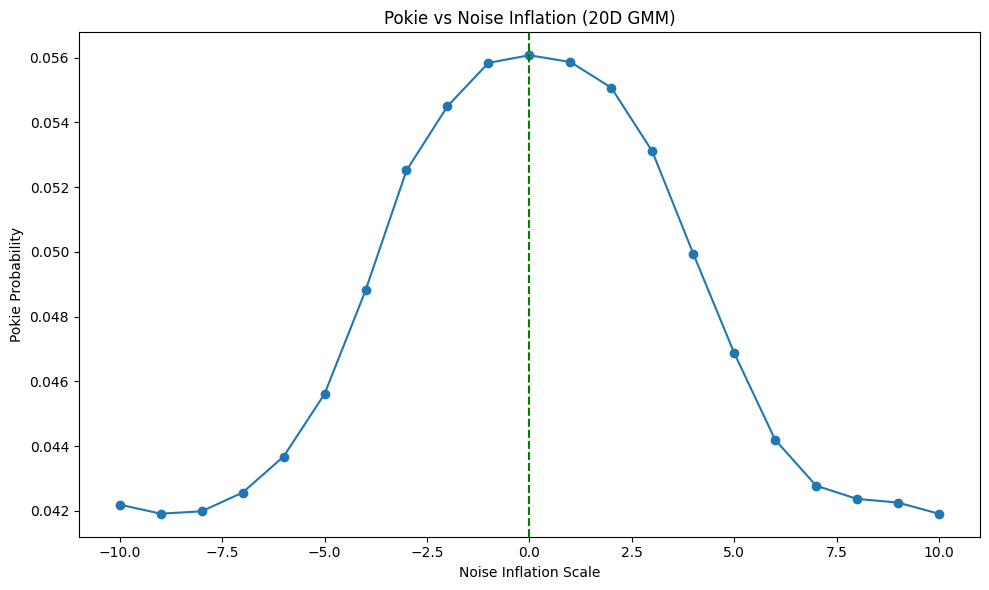

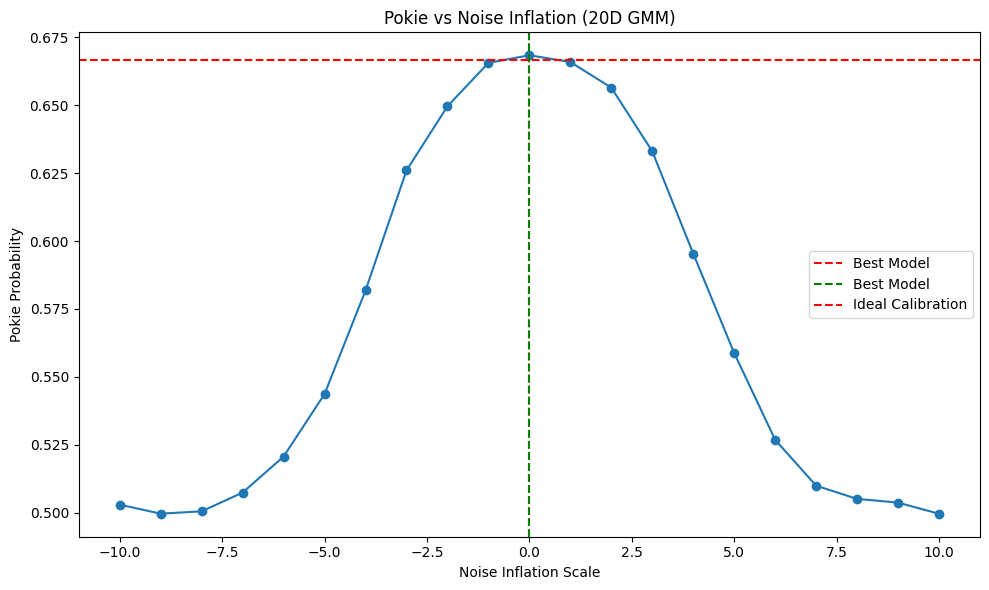

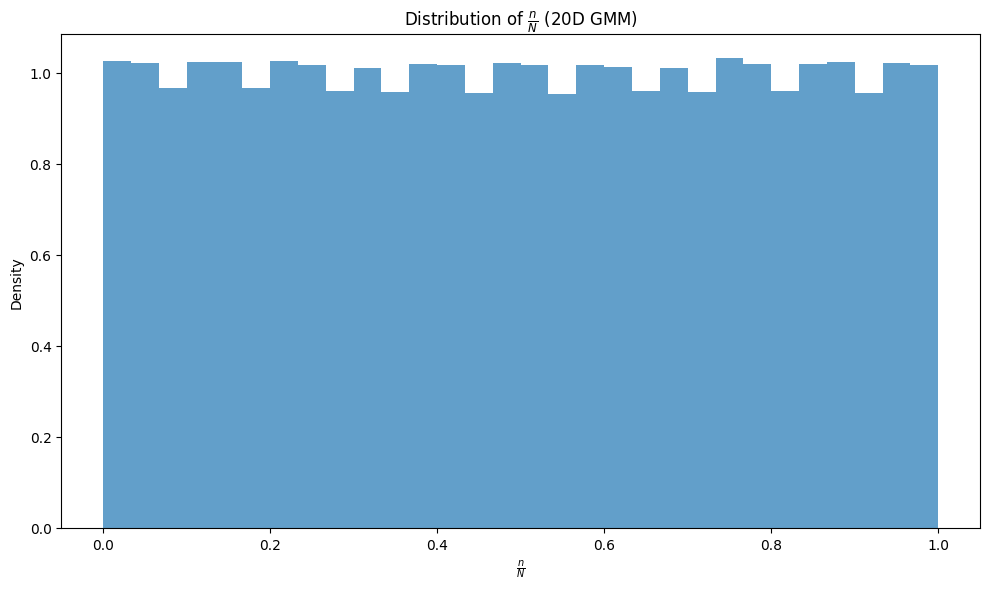

In [9]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_20D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_20D_GMM_Calibrated.pdf")
plt.show()

# Histogram of n/N values
plt.figure(figsize=(10, 6))
plt.hist(n_over_N_vals, bins=30, density=True, alpha=0.7)
plt.title(r"Distribution of $\frac{n}{N}$ (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/20D/Pokie_n_over_N_20D_GMM.pdf")
plt.show()

# 100 Dimension

In [10]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 100
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


In [11]:
results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

100%|██████████| 100/100 [38:54<00:00, 23.35s/it]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04471194 0.04501794 0.04441978 0.04478559 0.04482484 0.04476026
 0.04480006 0.04571125 0.05233906 0.05899912 0.05942588 0.05860063
 0.05201119 0.04594961 0.04472837 0.04489268 0.04475132 0.04487209
 0.04473997 0.04492557 0.04473286]
Calibrated: [0.5004302  0.503855   0.4971602  0.50125452 0.50169376 0.50097104
 0.50141648 0.51161476 0.58579536 0.66033684 0.66511324 0.65587676
 0.58212564 0.51428252 0.50061404 0.50245308 0.50087088 0.50222264
 0.50074392 0.50282116 0.50066436]


# 100D GMM Plots

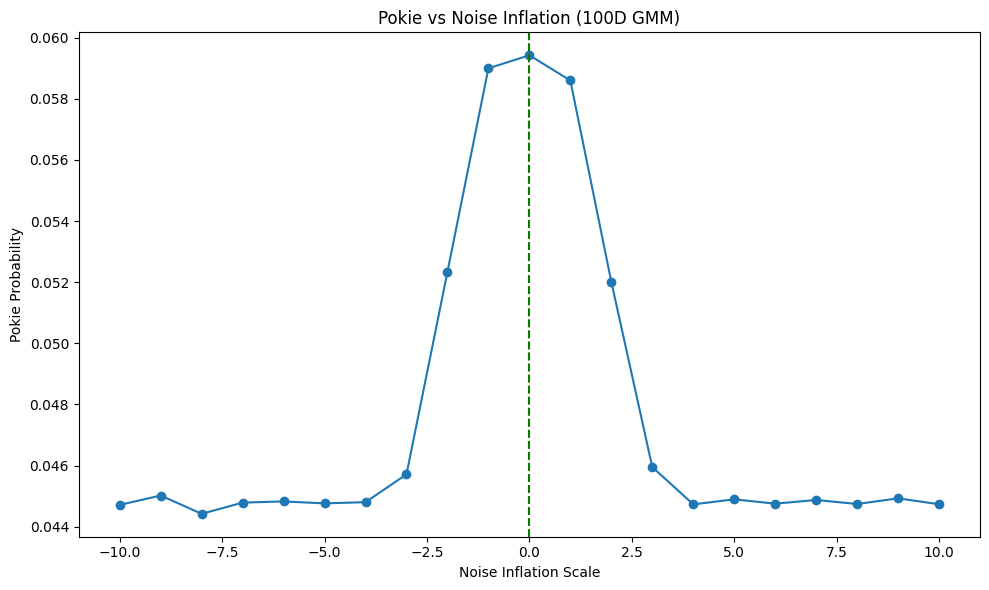

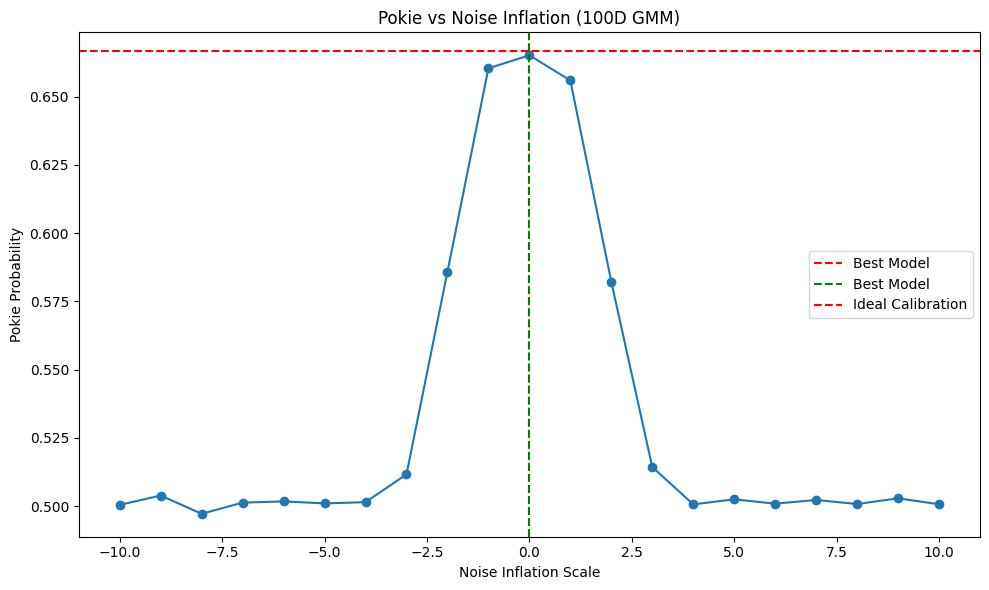

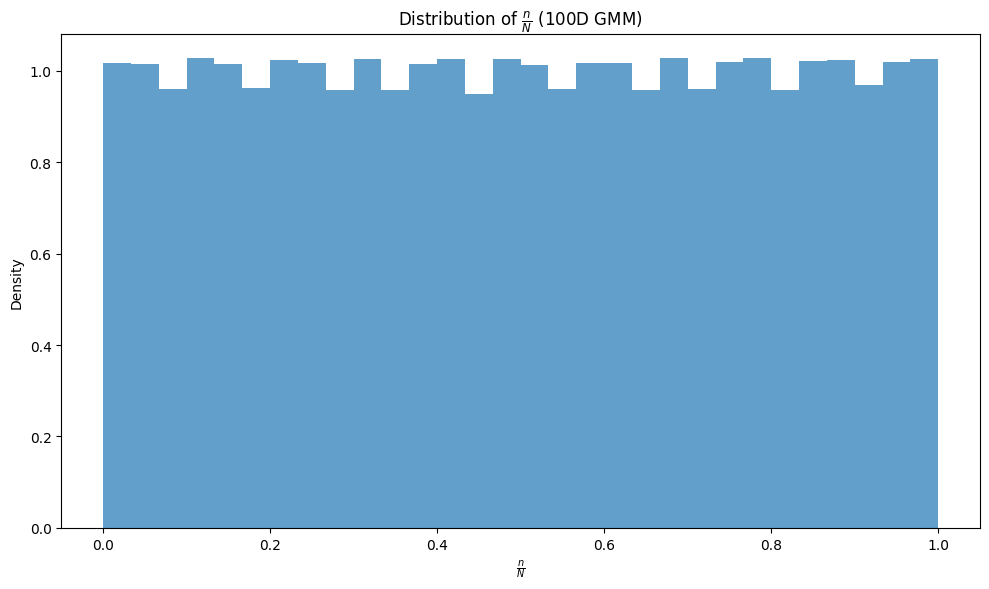

In [13]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_100D_GMM.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_100D_GMM_Calibrated.pdf")
plt.show()

# Histogram of n/N values
plt.figure(figsize=(10, 6))
plt.hist(n_over_N_vals, bins=30, density=True, alpha=0.7)
plt.title(r"Distribution of $\frac{n}{N}$ (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/GMM/100D/Pokie_n_over_N_100D_GMM.pdf")
plt.show()